In [38]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [39]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [40]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [41]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [42]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [43]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [44]:
# Save references to each table
Stations = Base.classes.station

Measurement = Base.classes.measurement

In [45]:
# Create our session (link) from Python to the DB
from sqlalchemy.orm import Session
session = Session(bind=engine)

# Exploratory Precipitation Analysis

In [56]:
# Find the most recent date in the data set.
from datetime import datetime as dt, timedelta

most_recent_date = session.query(func.max(Measurement.date)).scalar()

##most_recent_date = dt.strptime(most_recent_date_str, '%Y-%m-%d').date()

print("Most recent date in the data set:", most_recent_date)

Most recent date in the data set: 2017-08-23


<Figure size 1000x600 with 0 Axes>

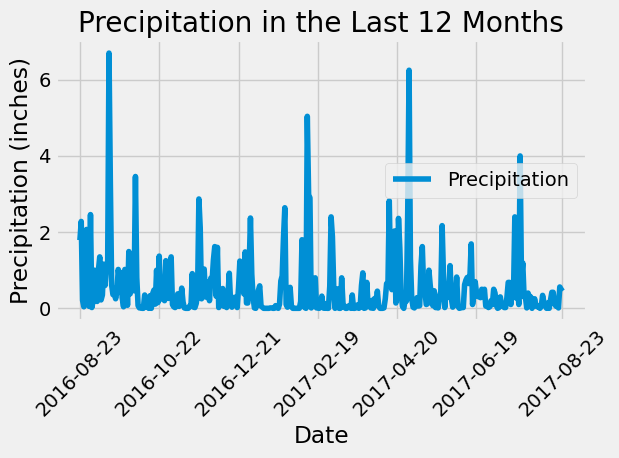

In [47]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
one_year_ago =  most_recent_date - timedelta(days=365)
one_year_ago 
# Perform a query to retrieve the data and precipitation scores
query_result = session.query(Measurement.date, func.Max(Measurement.prcp))\
    .filter(Measurement.date >= one_year_ago)\
    .group_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names

df = pd.DataFrame(query_result, columns=['Date', 'Precipitation'])
# Sort the dataframe by date

df.sort_values('Date')
# Use Pandas Plotting with Matplotlib to plot the data
df.set_index('Date', inplace = True)
plt.figure(figsize=(10, 6))
df.plot(xticks=(0,60,120,180,240,300,365))
plt.xlabel('Date')
plt.ylabel('Precipitation (inches)')
plt.title('Precipitation in the Last 12 Months')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [48]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_stats = df['Precipitation'].describe()
summary_stats

count    366.000000
mean       0.520765
std        0.830728
min        0.000000
25%        0.040000
50%        0.250000
75%        0.672500
max        6.700000
Name: Precipitation, dtype: float64

# Exploratory Station Analysis

In [49]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Stations.id)).scalar()
total_stations

9

In [50]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations_query = session.query(Measurement.station, func.count(Measurement.station).label('count')).\
                            group_by(Measurement.station)\
                            .order_by(func.count(Measurement.station).desc()).first()
print("Most active stations (descending order):")
if active_stations_query:
    station, count = active_stations_query
    print(f"Station: {station}, Count: {count}")

Most active stations (descending order):
Station: USC00519281, Count: 2772


In [51]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = active_stations_query[0][0]



# Query to calculate the lowest, highest, and average temperature for the most active station
temperature_stats_query = session.query(func.min(Measurement.tobs),
                                       func.max(Measurement.tobs),
                                       func.avg(Measurement.tobs)).\
                            filter(Measurement.station == most_active_station).all()
lowest_temp, highest_temp, avg_temp = temperature_stats_query[0]

In [57]:
most_active_station

'U'

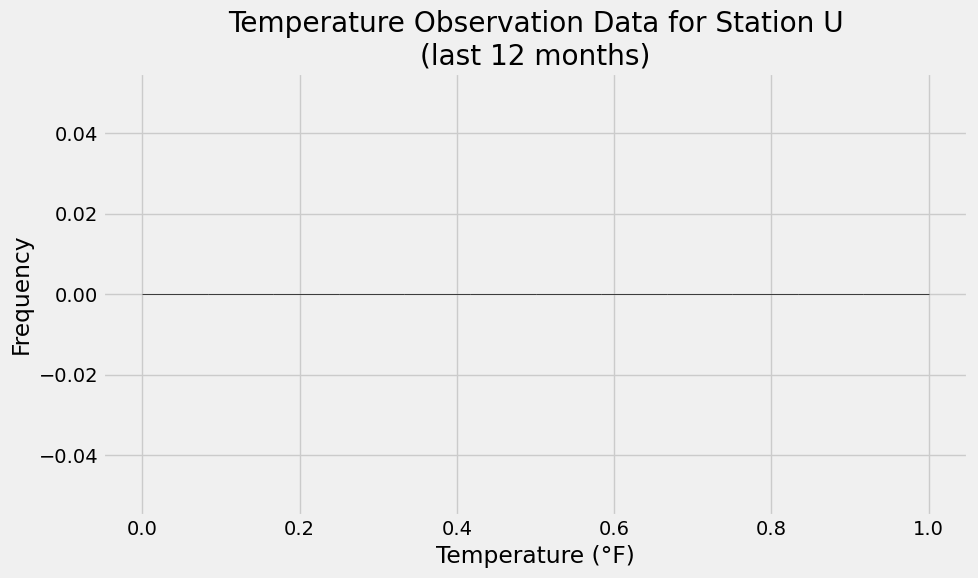

In [52]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temperature_observation_query = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.station == most_active_station, Measurement.date >= one_year_ago).all()

temperature_df = pd.DataFrame(temperature_observation_query, columns=['Date', 'Temperature'])

plt.figure(figsize=(10, 6))
plt.hist(temperature_df['Temperature'], bins=12, edgecolor='black')
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt.title(f'Temperature Observation Data for Station {most_active_station}\n(last 12 months)')
plt.tight_layout()
plt.show()

# Close Session

In [53]:
# Close Session
session.close()